In [1]:
# Importing dependencies and packages
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Using inspector to get column names
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Using inspector to get column names
inspector = inspect(engine)
columns2 = inspector.get_columns('Station')
for column in columns2:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(recent_date.date)

2017-08-23


In [125]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_before = dt.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, func.sum(Measurement.prcp)]
year_date = session.query(*sel).filter(func.strftime(Measurement.date)>=dt.date(2016, 8, 23)).\
    order_by(Measurement.date).group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_date, columns=['date', 'prcp'])
df = df.set_index('date')
df.head()


,prcp
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


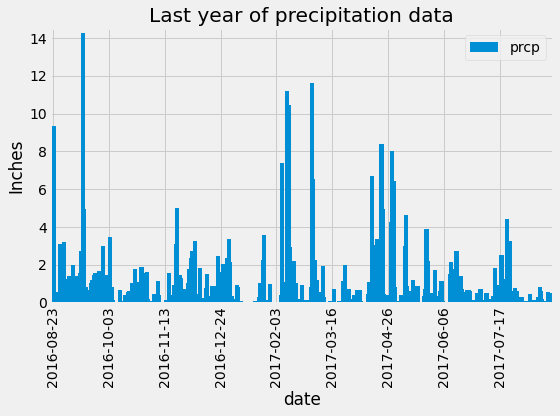

In [129]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_plot = df.plot(kind="bar", figsize=(8,6), ylabel="Inches", ylim=(0,(df['prcp'].max()+0.25)),
                            title="Last year of precipitation data", width=3)
plt.locator_params(nbins=9)
plt.tight_layout()

In [98]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Exploratory Station Analysis

In [99]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station).count()
total_stations

9

In [100]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Station.station, func.count(Station.id)]
activity = session.query(*sel).filter(Measurement.station == Station.station).group_by(Station.id).all()
df = pd.DataFrame(activity, columns=['Station', 'Count of Activity'])
df.sort_values('Count of Activity', ascending=False)

,Station,Count of Activity
6,USC00519281,2772
0,USC00519397,2724
1,USC00513117,2709
5,USC00519523,2669
8,USC00516128,2612
2,USC00514830,2202
7,USC00511918,1979
3,USC00517948,1372
4,USC00518838,511


In [101]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
temp = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
print(f"The lowest temp at station USC00519281 was {temp[0][0]}.")
print(f"The highest temp at station USC00519281 was {temp[0][1]}.")
print(f"The average temp at station USC00519281 was {round(temp[0][2],1)}.")

The lowest temp at station USC00519281 was 54.0.
The highest temp at station USC00519281 was 85.0.
The average temp at station USC00519281 was 71.7.


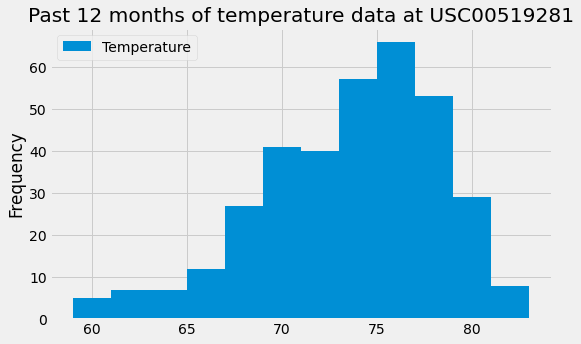

In [120]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281',\
    func.strftime(Measurement.date)>=dt.date(2016, 8, 23)).all()
df = pd.DataFrame(temp_data, columns=['Temperature'])
temperature_plot = df.plot(kind="hist", figsize=(8,5), xlabel='Temperature', ylabel="Frequency", bins=12, 
                          title="Past 12 months of temperature data at USC00519281")

# Close session

In [124]:
# Close Session
session.close()